In [1]:
import cv2
import pickle
import numpy as np
import camutils as cu
import meshutils as mu
import matplotlib.pyplot as plt
import visutils

In [2]:
# %load_ext autoreload
# %autoreload 2

# Object Reconstruction From a Collection of Structured Light Scans

---
**name:** Erik Gomez

**SID:** 38017181

Camera : 
 f=1404.6009665805618 
 c=[[962.16736516 590.91595793]] 
 R=[[ 0.03843674  0.98947412  0.13951198]
 [ 0.97735771 -0.00815435 -0.21143654]
 [-0.20807335  0.14448004 -0.96738358]] 
 t = [[ 6.86588585 19.52346881 47.34419208]]
Camera : 
 f=1404.6009665805618 
 c=[[962.16736516 590.91595793]] 
 R=[[-0.00259873  0.99096863  0.1340687 ]
 [ 0.99277876 -0.01352251  0.11919515]
 [ 0.1199316   0.13341031 -0.98377746]] 
 t = [[ 7.50009897  7.20926532 47.76495344]]


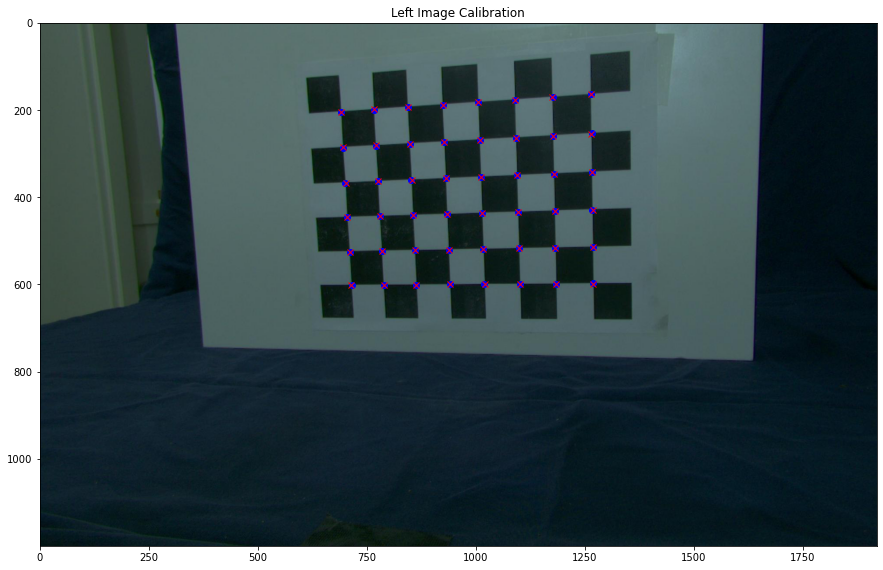

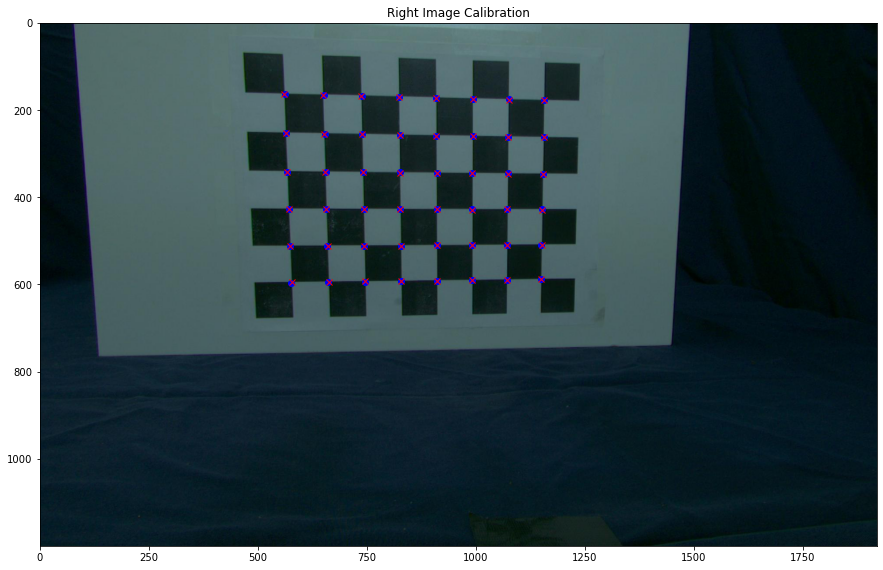

In [3]:
"""
The code below was taken from my Assignment3, with some modifactions
"""
# using calibrate.py we estimate the intrinsic camera parameters
# from the provided calibration images (calib_jpg_u)

# load in the intrinsic camera parameters from 'calibration.pickle'
intrinsic_params = pickle.load(open('calibration.pickle', 'rb'))

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
f = (intrinsic_params['fx'] + intrinsic_params['fy']) / 2
c = np.array([[intrinsic_params['cx']],[intrinsic_params['cy']]])
R = cu.makerotation(0,0,0)
t = np.array([[0,0,0]]).T

camL = cu.Camera(f,c,R,t)
camR = cu.Camera(f,c,R,t)

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib_jpg_u/frame_C0_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib_jpg_u/frame_C1_01.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

# Now use  calibratePose function to get the extrinsic parameters
# for the two images. May need to experiment with the initialization
# in order to get a good result

params_l = np.array([0,1,0,0,0,-1]) 
params_r = np.array([0,-1,0,0,0,-1])  

camL = cu.calibratePose(pts3, pts2L, camL, params_l)
camR = cu.calibratePose(pts3, pts2R, camR, params_r)

print(camL)
print(camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.title("Left Image Calibration")
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.title("Right Image Calibration")
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()

In [25]:
imprefix = 'couple/grab_0_u/frame_c0_'
color_imprefix = 'couple/grab_0_u/color_C0_'
# found that these values resulted in the best outputs
threshold = 0.006
color_thresh = 0.01
#threshold = 0.01  # teapot
#color_thresh = 0.01  # teapot
code, mask, color_mask = cu.decode(imprefix, color_imprefix, 0, threshold, color_thresh)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )



[]

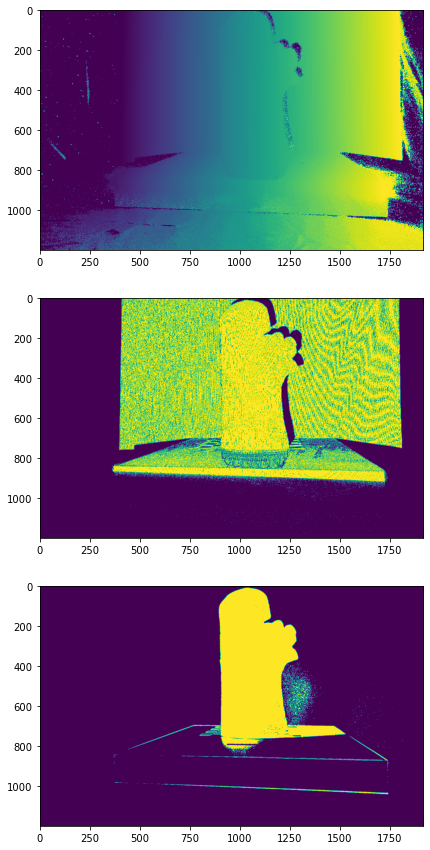

In [26]:
# display view code and mask as images
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.imshow(code)
ax2.imshow(mask)
ax3.imshow(color_mask)
plt.plot()

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



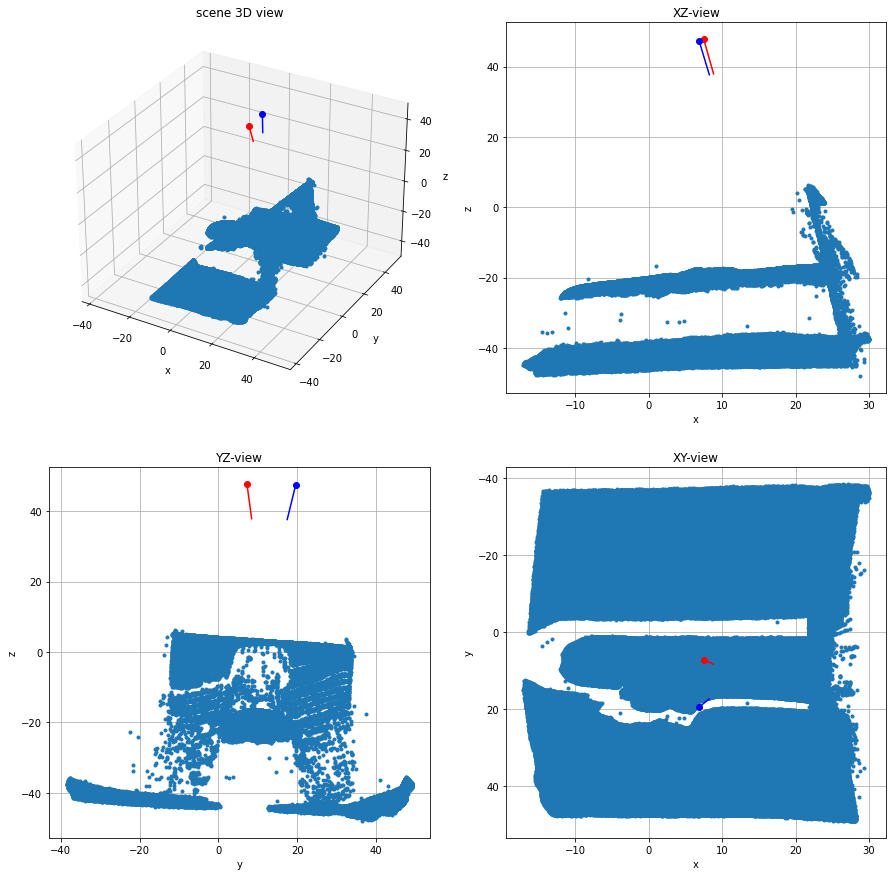

In [27]:
imprefixLF = 'couple/grab_0_u/frame_c0_'
imprefixLC = 'couple/grab_0_u/color_c0_'

imprefixRF = 'couple/grab_0_u/frame_c1_'
imprefixRC = 'couple/grab_0_u/color_c1_'


#
# Reconstruct and visualize the results before mesh cleanup
#
pts2L,pts2R,pts3,rgbs = cu.reconstruct(imprefixLF,imprefixLC,imprefixRF,imprefixRC,threshold,color_thresh,camL,camR)

# visualize 3D layout of points, camera positions
# and the direction the camera is pointing
visutils.vis_scene(camL,camR,pts3,looklength=10)

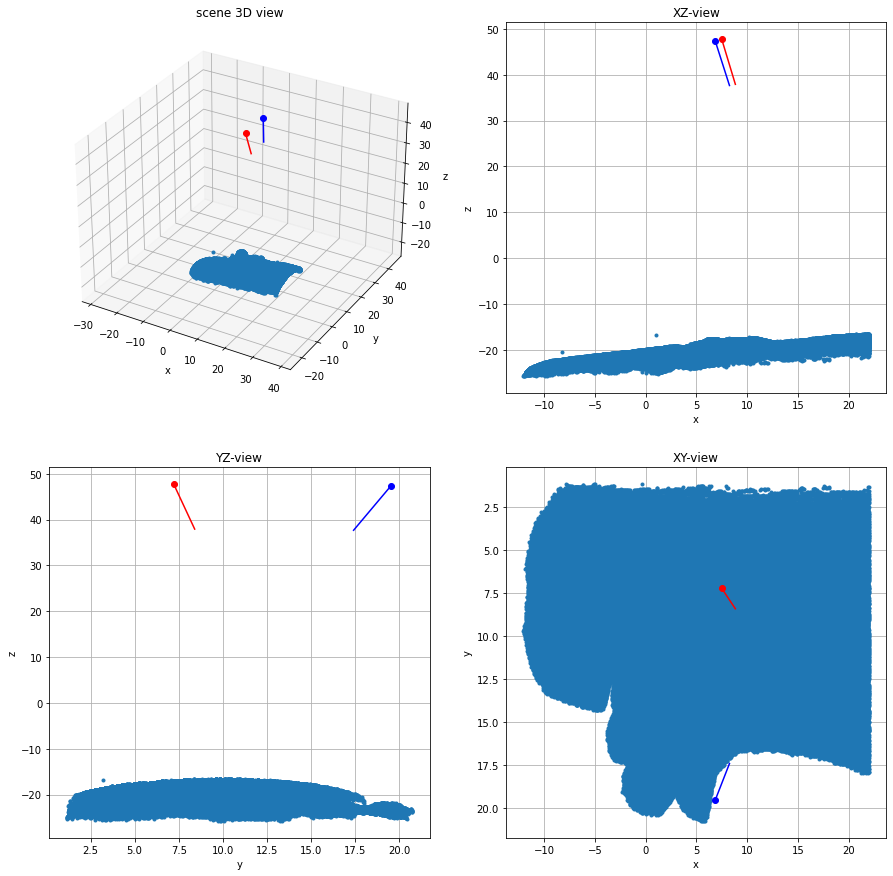

In [28]:
#
# Visualize the results after bounding box
#
box_limits = np.array([-15,22,0,22,-30,-15])
# box_limits = np.array([0,18,0,23,17,26])  # box limits for teapot
pts3,pts2L,pts2R,rgbs = cu.bounding_box_pruning(box_limits,pts3,pts2L,pts2R,rgbs)

visutils.vis_scene(camL,camR,pts3,looklength=10)

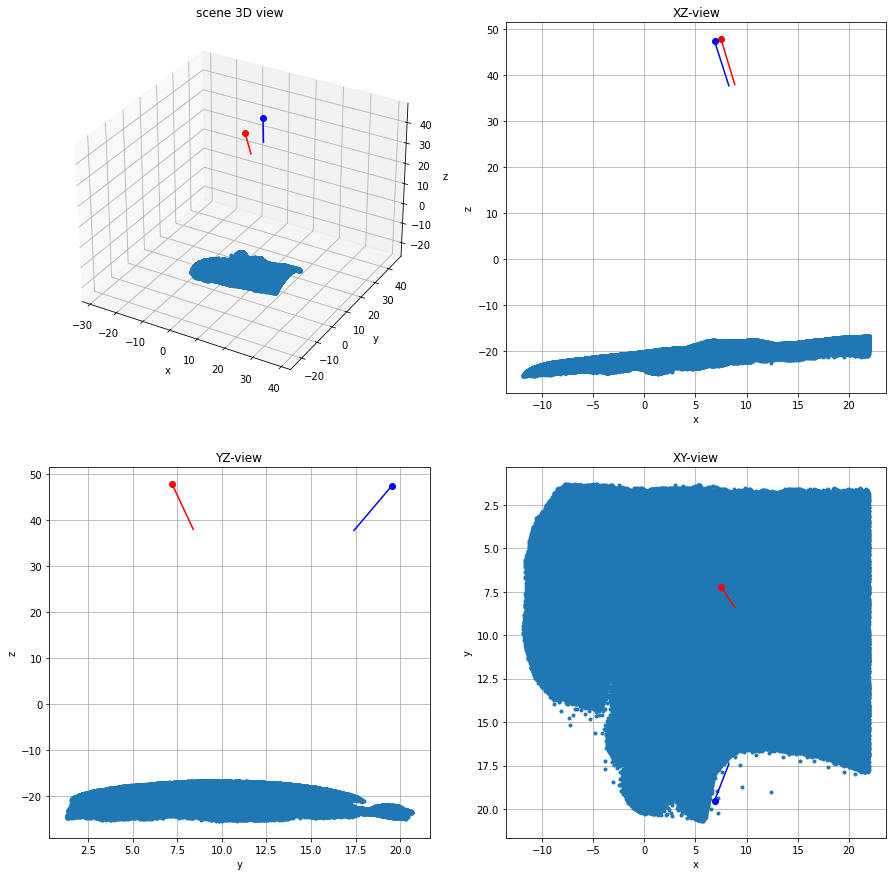

In [29]:
from scipy.spatial import Delaunay
#
# triangulate the 2D points to get the surface mesh
#
tri = Delaunay(pts2L.T)
s = tri.simplices
#
# Visualize the results after mesh smoothing
#
pts3 = cu.mesh_smoothing(pts3,tri,pts3.shape[1])
visutils.vis_scene(camL,camR,pts3,looklength=10)

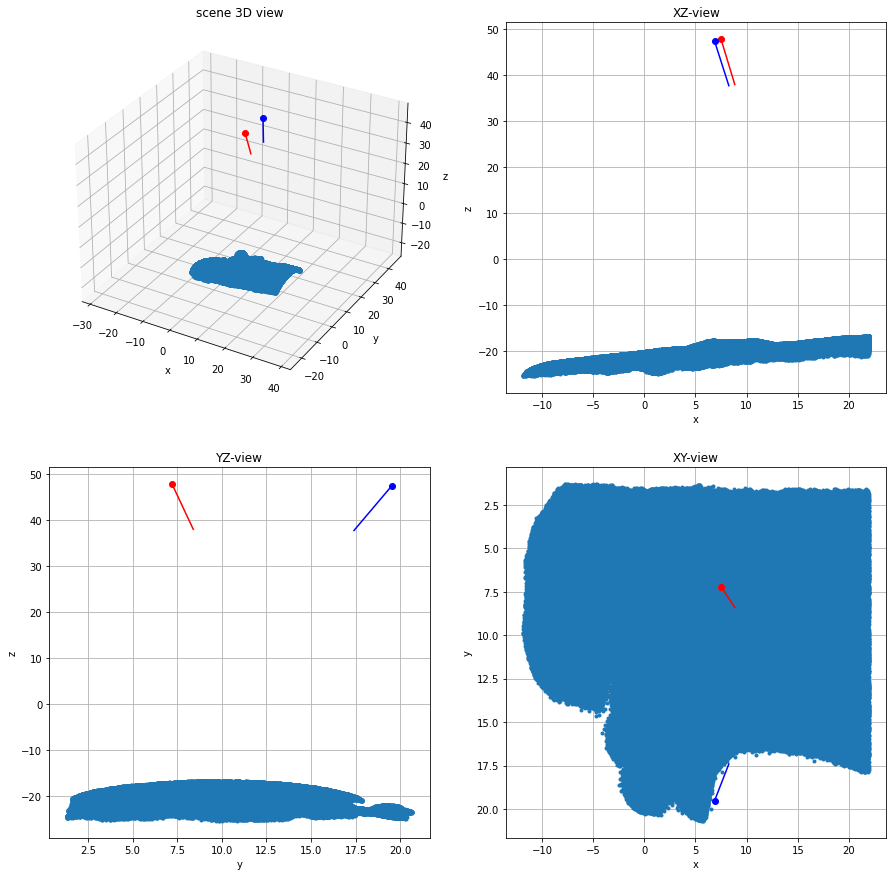

In [30]:
#
# triangle pruning
#

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value

trithresh = 0.5

allowed_edges = np.where( 
                 (np.sqrt(np.sum(np.power(pts3[:,s[:,0]] - pts3[:,s[:,1]],2),axis=0)) < trithresh) &\
                 (np.sqrt(np.sum(np.power(pts3[:,s[:,0]] - pts3[:,s[:,2]],2),axis=0)) < trithresh) &\
                 (np.sqrt(np.sum(np.power(pts3[:,s[:,1]] - pts3[:,s[:,2]],2),axis=0)) < trithresh))

s = s[allowed_edges]
to_keep = np.unique(s)
map_ = np.zeros(pts3.shape[1])

pts3 = pts3[:, to_keep]
pts2L = pts2L[:, to_keep]
pts2R = pts2R[:, to_keep]
rgbs = rgbs[:, to_keep]

map_[to_keep] = np.arange(0, (to_keep).shape[0])
s = map_[s]

visutils.vis_scene(camL,camR,pts3,looklength=10)

In [10]:
# cell to keep track of threshold values that work for each grab_{}
# grab0: (0.001, 0.01, 0.5, smoothing=3, box_limits=np.array([-15,22,0,22,-30,-15]))
# grab1: (0.01, 0.01, 20, smoothing, box_limits)
# grab2: (0.006, 0.01, 1, smoothing, box_limits=np.array([-15,30,0,22,-40,-10]))
# grab3: (0.006, 0.01, 0.5, smoothing, box_limits=np.array([-15,30,0,22,-40,-10]))
# grab4: (0.006, 0.01, 0.5, smoothing, box_limits=np.array([-15,24,8,18,-22,-10]))
# grab5: (0.006, 0.01, 0.5, smoothing, box_limits)
# grab6: (0.006, 0.01, 0.5, smoothing, box_limits)

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



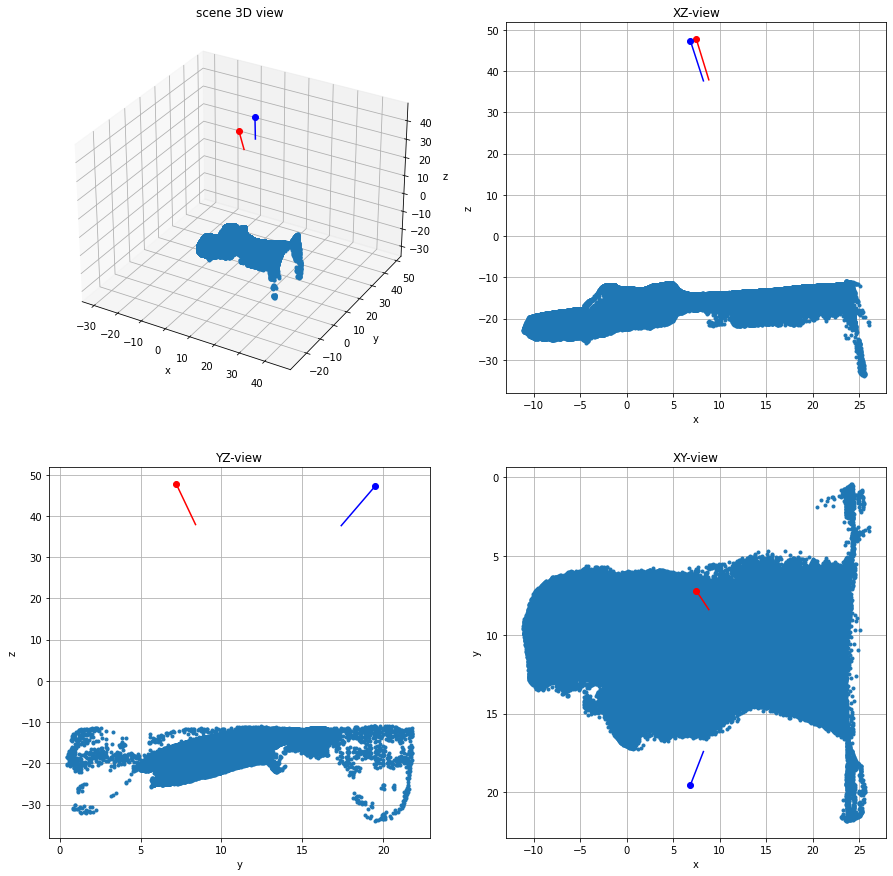

In [14]:
for i in range(7):
    imprefixLC = 'couple/grab_{}_u/color_C0_'.format(i)
    imprefixLF = 'couple/grab_{}_u/frame_C0_'.format(i)
    imprefixRC = 'couple/grab_{}_u/color_C1_'.format(i)
    imprefixRF = 'couple/grab_{}_u/frame_C1_'.format(i)
    
    #threshold = 0.006
    #threshold = 0.006
    #color_thresh = 0.01
    threshold = 0.01
    color_thresh = 0.01
    
    pts2L, pts2R, pts3, rgbs = cu.reconstruct(imprefixLF, 
                                              imprefixLC, 
                                              imprefixRF, 
                                              imprefixRC, 
                                              threshold, color_thresh, camL, camR)
    
    box_limits = np.array([-15,30,0,22,-40,-10])
    
    #trithresh = 5
    #trithresh = 20
    #trithresh = 0.5
    trithresh = 1
    pts3, tri, rgbs = cu.mesh_gen(pts3, pts2L, pts2R, rgbs, box_limits, trithresh)
     
    visutils.vis_scene(camL,camR,pts3,looklength=10)
    mu.writeply(pts3,rgbs,tri,'grab{}_.ply'.format(i))
